In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")
from robot_model import *
torch.manual_seed(42)
np.random.seed(42)

from stable_baselines3 import PPO, DDPG, TD3
from robot_model import CDPR4_env, CDPR4

device = torch.device("cpu")

## Models loading

In [2]:
robot_model = CDPR4_env(pos=np.array([.0, .0, 1.]))
modelSB3_PPO = PPO.load("models/ppo_cdpr4_model_3m_timesteps.zip", env=robot_model, custom_objects={'observation_space': robot_model.observation_space, 'action_space': robot_model.action_space}, print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: macOS-15.1.1-arm64-arm-64bit Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.0-125-generic-x86_64-with-glibc2.35 # 135-Ubuntu SMP Fri Sep 27 13:53:58 UTC 2024
- Python: 3.10.12
- Stable-Baselines3: 2.4.0
- PyTorch: 2.4.0+cu124
- GPU Enabled: True
- Numpy: 1.26.1
- Cloudpickle: 3.0.0
- Gymnasium: 1.0.0

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Robot simulation and graph plotting functions

In [3]:
dt = 0.1
robot_model.dt = dt
max_force = 15
action_decoder = {
            i: np.array([int(b) for b in f'{i:04b}']) for i in range(16)
        }

def system(model, X, t_span, robot_model):
    global dt
    
    obs = np.copy(X)
    states = np.zeros((t_span.shape[0], 6))
    states[0, :] = X[:6]
    step_count = 1  # Initialize step counter
    done = False
    
    # go to position
    while not done and step_count < t_span.shape[0]:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = robot_model.step(action)
        states[step_count, :] = obs[:6]
        step_count += 1

    if step_count< t_span.shape[0]:
        obs = np.hstack((states[step_count, :], X[3:6]))
    else:
        return states, done

    # try to hold the position
    while step_count<t_span.shape[0]:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = robot_model.step(action)
        states[step_count, :] = obs[:6]
        step_count += 1

    return states, done

In [4]:
import matplotlib.pyplot as plt

def plot_states(sol, t_span):
    plt.figure(figsize=(10, 6))
    plt.plot(t_span, sol[:,0], label='x')
    plt.plot(t_span, sol[:,1], label='y')
    plt.plot(t_span, sol[:,2], label='z')
    # plt.plot(t_span, sol[:,3], label='dx')
    # plt.plot(t_span, sol[:,4], label='dy')
    # plt.plot(t_span, sol[:,5], label='dz')
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title('System')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_position_error(actual_x, desired_x, t_span):
    if desired_x.shape[0] == 3:
        err = np.array([desired_x - actual_x[i, :3] for i in range(actual_x.shape[0])])
        plt.figure(figsize=(10, 6))
        plt.plot(t_span, err[:,0], label='x err')
        plt.plot(t_span, err[:,1], label='y err')
        plt.plot(t_span, err[:,2], label='z err')
        plt.plot(t_span, [np.linalg.norm(i) for i in err], label='abs err')
        plt.xlabel('Time')
        plt.ylabel('State Variables')
        plt.title('Position Errors')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        err = np.array([desired_x[i, :3] - actual_x[i, :3] for i in range(actual_x.shape[0])])
        plt.figure(figsize=(10, 6))
        plt.plot(t_span, err[:,0], label='x err')
        plt.plot(t_span, err[:,1], label='y err')
        plt.plot(t_span, err[:,2], label='z err')
        plt.plot(t_span, [np.linalg.norm(i) for i in err], label='abs err')
        plt.xlabel('Time')
        plt.ylabel('State Variables')
        plt.title('Position Errors')
        plt.legend()
        plt.grid(True)
        plt.show()
    
def get_rms_err(actual_x, desired_x, t_span):
    abs_err = np.array([np.linalg.norm(desired_x - actual_x[i, :3]) for i in range(actual_x.shape[0])]) 
    mean_err = np.mean(abs_err**2)
    return np.sqrt(mean_err)

def plot_error(errors, title='Error Over Time', xlabel='Time Steps', ylabel='Error'):
    """
    Plot the error over time.
    
    Parameters:
    errors (np.array): Array of errors with shape (n,)
    title (str): Title of the plot
    xlabel (str): Label for the x-axis
    ylabel (str): Label for the y-axis
    """
    
    # Ensure errors is a numpy array
    errors = np.array(errors)
    
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot the errors
    plt.plot(errors, color='blue', linewidth=2, label='Error')
    
    # Set titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Add grid for better readability
    plt.grid(True)
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

    

In [5]:
from scipy.spatial.distance import euclidean
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def horizontal_circle_trajectory_points(t_span, h=1.0):
    """
    Horizontal circle trajectory: R=0.5m, on heigth h=1m
    
    Parameters:
    t_span: np.array
    h: float
    """
    R=0.5
    h=1.0
    n = t_span.shape[0] # n points in trajectory
    phi = np.linspace(0, 2*np.pi, n)
    
    trajectory = np.zeros((n, 3))
    trajectory[:, 0] = R*np.cos(phi) # X
    trajectory[:, 1] = R*np.sin(phi) # Y
    trajectory[:, 2] = h # Z
        
    return trajectory


def plot_trajectory_3d(points):
    """
    Plot a 3D trajectory given an array of points.
    
    Parameters:
    points (np.array): Array of shape (n, 3) containing x, y, z coordinates.
    """
    # Ensure the input is a numpy array
    points = np.array(points)
    
    # Check if the shape is correct
    if points.shape[1] != 3:
        raise ValueError("Input array must have shape (n, 3)")
    
    # Extract x, y, z coordinates
    x, y, z = points.T
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory
    ax.plot(x, y, z, label='Trajectory')
    
    # Plot start and end points
    ax.scatter(x[0], y[0], z[0], color='green', s=100, label='Start')
    ax.scatter(x[-1], y[-1], z[-1], color='red', s=100, label='End')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Trajectory')
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()

def follow_trajectory(model, initial_state, trajectory, robot_model, max_steps=200, dt=0.1):
    """
    Function for a robot to follow a given trajectory using an RL model.
    
    Parameters:
    model: The RL model used for prediction
    initial_state: Initial state of the robot (numpy array)
    trajectory: Array of points to follow (shape: n x 3)
    robot_model: The robot model object
    max_steps: Maximum number of steps to simulate
    dt: Time step for simulation
    
    Returns:
    states: Array of robot states throughout the simulation
    reached_points: List of indices of reached trajectory points
    """
    
    X = initial_state.copy()
    states = np.zeros((max_steps, 3))
    states[0,:] = X[:3].copy()
    reached_points = []
    step_count = 0
    current_target = 1
    finished = False
    abs_err = [.0] # initial point is the first trajectory point
    
    while not finished and step_count<max_steps:
        
        # go to next point
        done = False
        while not done:
            action, _states = model.predict(X, deterministic=True)
            X, reward, done, truncated, info = robot_model.step(action)
            states[step_count, :] = X[:3]
            step_count += 1
        
        abs_err.append(euclidean(X[:3], trajectory[current_target]))
        # switch to next point
        current_target += 1
        if current_target == trajectory.shape[0]:
            finished = True
            break
        # update next point
        X[6:9] = trajectory[current_target]
    
    return np.array(states), reached_points, np.array(abs_err)

def visualize_simulation(trajectory, robot_states, reached_points, interval=100, save_animation=False, gif_name='base_model'):
    """
    Visualize the simulation of the robot following a trajectory.
    
    Parameters:
    trajectory: Array of target points (shape: n x 3)
    robot_states: Array of robot states throughout the simulation (shape: m x 6)
    reached_points: List of indices of reached trajectory points
    interval: Interval between frames in milliseconds
    save_animation: Boolean, whether to save the animation as a gif
    """
    
    # Extract robot positions from states
    robot_positions = robot_states[:, :3]
    
    # Create the figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the target trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b--', label='Target Trajectory')
    
    # Plot start and end points of the target trajectory
    ax.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2], color='green', s=100, label='Start')
    ax.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2], color='red', s=100, label='End')
    
    # Initialize the robot position plot
    robot_plot, = ax.plot([], [], [], 'ro-', label='Robot Path', markersize=8)
    current_pos, = ax.plot([], [], [], 'ko', markersize=10, label='Current Position')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Robot Trajectory Simulation')
    ax.legend()
    
    # Set axis limits
    ax.set_xlim([min(trajectory[:, 0].min(), robot_positions[:, 0].min()) - 1,
                 max(trajectory[:, 0].max(), robot_positions[:, 0].max()) + 1])
    ax.set_ylim([min(trajectory[:, 1].min(), robot_positions[:, 1].min()) - 1,
                 max(trajectory[:, 1].max(), robot_positions[:, 1].max()) + 1])
    ax.set_zlim([min(trajectory[:, 2].min(), robot_positions[:, 2].min()) - 1,
                 max(trajectory[:, 2].max(), robot_positions[:, 2].max()) + 1])
    
    # Animation update function
    def update(frame):
        robot_plot.set_data(robot_positions[:frame, 0], robot_positions[:frame, 1])
        robot_plot.set_3d_properties(robot_positions[:frame, 2])
        current_pos.set_data([robot_positions[frame, 0]], [robot_positions[frame, 1]])
        current_pos.set_3d_properties([robot_positions[frame, 2]])
        
        # Highlight reached points
        for point in reached_points:
            if frame >= point:
                ax.scatter(trajectory[point, 0], trajectory[point, 1], trajectory[point, 2], 
                           color='green', s=100, alpha=0.5)
        
        return robot_plot, current_pos
    
    # Create the animation
    anim = FuncAnimation(fig, update, frames=len(robot_positions), interval=interval, blit=True)
    
    if save_animation:
        anim.save(f'visualizations/robot_trajectory_simulation_{gif_name}.gif', writer='pillow')
    
    plt.show()

## PPO

In [6]:
eps = 500
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)
des_pos = np.array([0,0,2], dtype=np.float32)
X = np.hstack([X, des_pos])
robot_model.cur_state = X

sol1, d = system(modelSB3_PPO, X, t_span, robot_model)

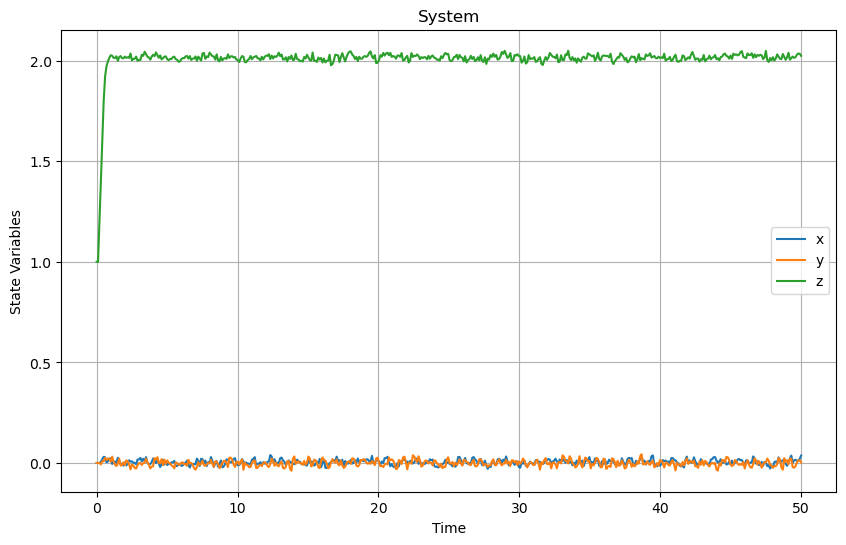

In [7]:
plot_states(sol1, t_span)

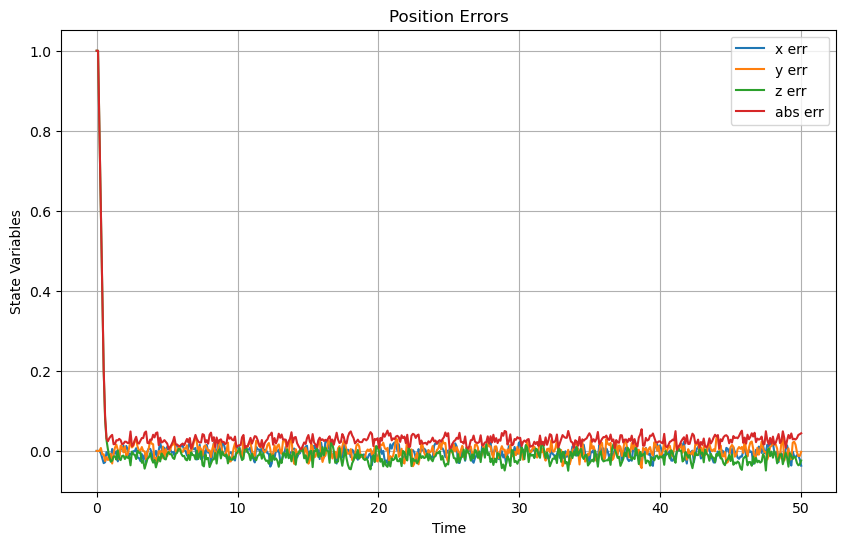

In [8]:
plot_position_error(sol1, des_pos, t_span)

In [9]:
get_rms_err(sol1[15:], des_pos, t_span[15:])

0.029156658327905184

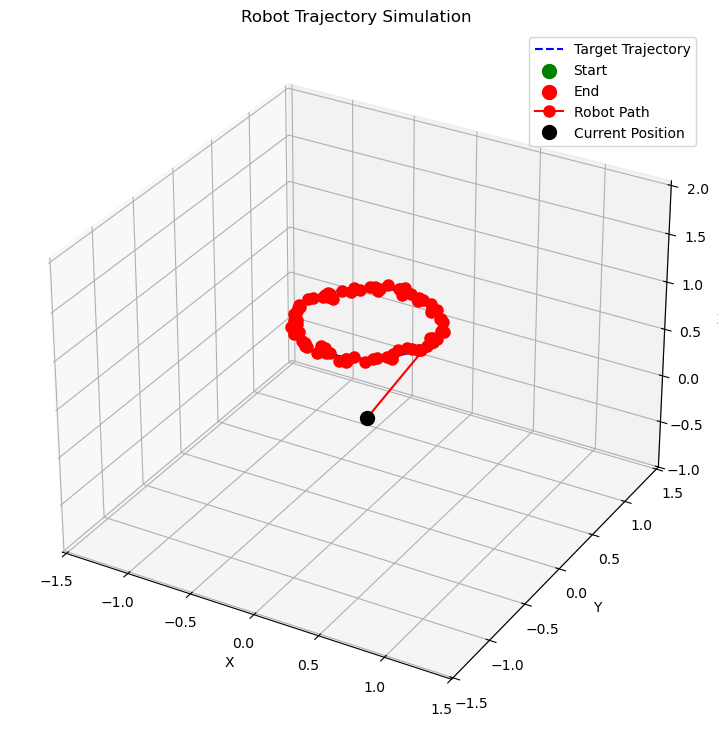

In [10]:
traj1 = horizontal_circle_trajectory_points(t_span = np.linspace(0, 10, 20)) 
 
robot_model.cur_state = np.hstack((traj1[0], 
                                   np.zeros(3),
                                   traj1[1]))

states, reached_p, error = follow_trajectory(model=modelSB3_PPO, 
                  initial_state=np.hstack((traj1[0], 
                                   np.zeros(3),
                                   traj1[1])), 
                  trajectory=traj1, 
                  robot_model=robot_model)
visualize_simulation(trajectory=traj1, 
                     robot_states=states,
                     reached_points=reached_p,
                     save_animation=True,
                     gif_name='PPO')

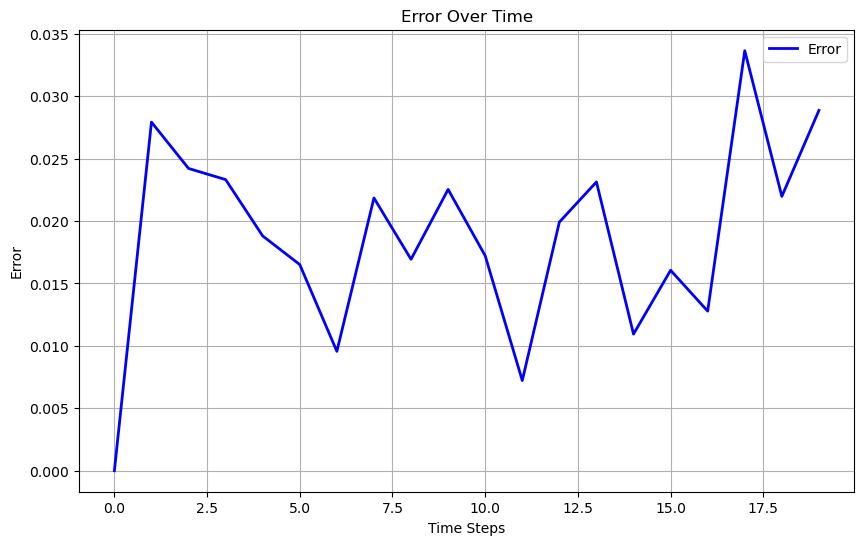

In [11]:
# plotting abs error of trajectory
plot_error(error)

In [12]:
# RMS Error
mean_err = np.mean(error**2)
np.sqrt(mean_err)

0.02020416693338823

## DDPG

In [13]:
robot_model_td3 = CDPR4_env(pos=np.array([.0, .0, 1.]), is_continuous=True)
modelSB3_TD3 = TD3.load("models/mi93o31c/ddpg_cdpr4_model.zip", env=robot_model_td3, custom_objects={'observation_space': robot_model_td3.observation_space, 'action_space': robot_model_td3.action_space}, print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: macOS-15.1.1-arm64-arm-64bit Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1

== SAVED MODEL SYSTEM INFO ==
- OS: macOS-15.1.1-arm64-arm-64bit Darwin Kernel Version 24.1.0: Thu Oct 10 21:03:15 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T6000
- Python: 3.9.20
- Stable-Baselines3: 2.3.2
- PyTorch: 2.4.1.post3
- GPU Enabled: False
- Numpy: 1.23.1
- Cloudpickle: 3.1.0
- Gymnasium: 0.29.1
- OpenAI Gym: 0.26.1



In [14]:
eps = 500
t_span = np.linspace(0, dt*eps, eps)
X=np.array([0,0,1,0,0,0], dtype=np.float32)
des_pos = np.array([0,0,2], dtype=np.float32)
X = np.hstack([X, des_pos])
robot_model_td3.cur_state = X

sol_td3, d = system(modelSB3_TD3, X, t_span, robot_model_td3)

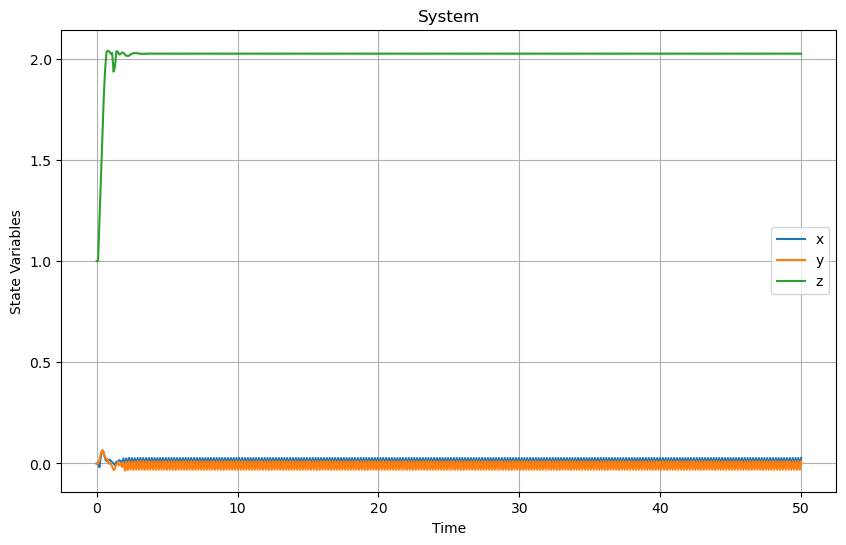

In [15]:
plot_states(sol_td3, t_span)

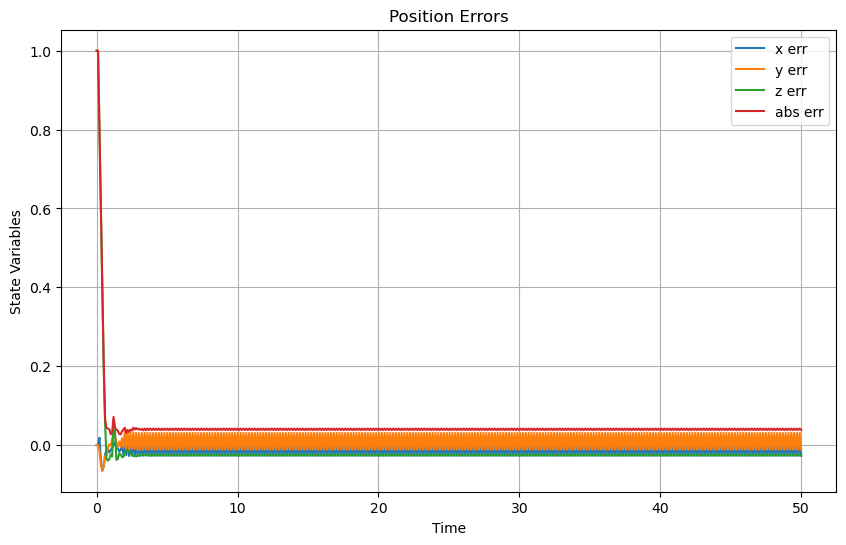

In [16]:
plot_position_error(sol_td3, des_pos, t_span)

In [17]:
get_rms_err(sol_td3[15:], des_pos, t_span[15:])

0.039983703571564264

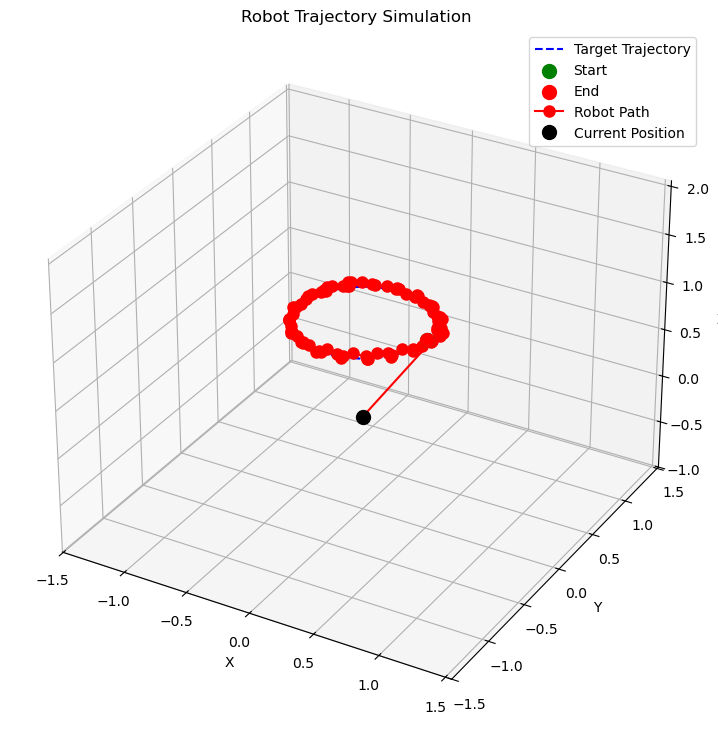

In [18]:
robot_model_td3.cur_state = np.hstack((traj1[0], 
                                   np.zeros(3),
                                   traj1[1]))

states, reached_p, error = follow_trajectory(model=modelSB3_TD3, 
                  initial_state=np.hstack((traj1[0], 
                                   np.zeros(3),
                                   traj1[1])), 
                  trajectory=traj1, 
                  robot_model=robot_model_td3)
visualize_simulation(trajectory=traj1, 
                     robot_states=states,
                     reached_points=reached_p,
                     save_animation=True,
                     gif_name='TD3')

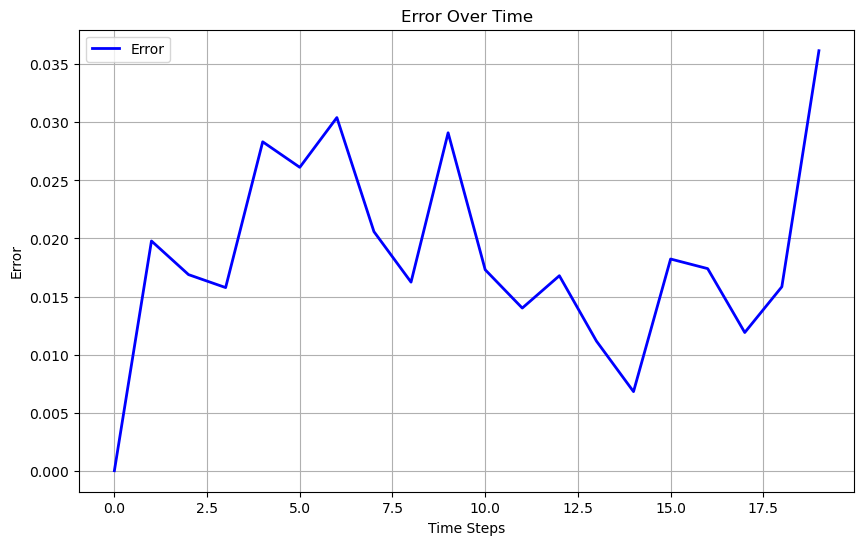

In [19]:
# plotting abs error of trajectory
plot_error(error)

In [20]:
# RMS Error
mean_err = np.mean(error**2)
np.sqrt(mean_err)

0.020191941632671625